# Radiative Transfer Model
Throughout the previous chapter, we have been laying the groundwork for building the final model. This page walks throughout the important sections of the implementation in python. The code that is run in this section to generate the plots, uses the SimpleTrans package, however the snippets of code shown are intended as a conceptual walk through of how the program runs and how the solution is implemented rather than the exact code in the module as, this is likely to change.

```{python}
class AtmosphereGrid:
    def __init__(
        self,
        alt_range: Tuple[float, float],
        wave_no_range: Tuple[float, float],
        *gas: str,
        verbose=False,
        db_connection: sqlite3.Connection = default_db(),
    ):
```
To solve the two stream equations, as mentioned before we make an atmosphere grid. A class implementation was chosen, because the object can be initialized to store a model atmosphere that can then be used multiple times. When `__init__` a [dunder](https://www.geeksforgeeks.org/dunder-magic-methods-python/)  is run, the Class's attributes are assigned. For the most part these are storing the variables passed when the class is initialized. However, the `fetch_od_from_db` function and `get_optical_depth` method are run to query the optical depths database. The `fetch_od_from_db`, requests the optical depths for a single gas, and performs the binning. Then it returns a dataframe of optical depths, with columns for each altitude present in the database inside the requested range. The `get_optical_depth` method of the class calls the `fetch_od_from_db` for each `*gas` passed and combines the optical depths. This can be slightly challenging when larger wavenumber bins are used, as adding optical depths together depends on how correlated the two gases peaks are across the [bin](https://ereader.cambridge.org/wr/viewer.html#book/95232efd-fe8e-4b72-ad9e-c3f22d2a0cda/ichap4){cite}`pierrehumbert_2010`. With the small bins implemented here, the optical depths can just be added across the bin and assumed independent.

Mechanically `fetch_od_from_db` queries the database inside the ranges passed to `AtmosphereGrid`. On the results of the query, all the wavenumbers are rounded to the nearest integer, and the optical depth values associated with each integer are averaged over. The `get_optical_depth` method applies this to multiple gases and performs additions of the optical depth values. To get the total optical depth grid.

```{note}
In the implementation of the atmosphere grid class most of the quantities calculated are solved on grids of the same size (number of altitudes, number of integer wavenumbers). The quantities are; optical depth, blackbody radiation, transmission function and spectral radiance. This enables speedups through numpy vectorisation.
```
The main goal was to produce a radiation transfer model, for this we solve the discrete two stream equations eq.{eq}`grid_up_flux`. So rather than solving for a specific altitude, the `up_flux` method solves for all altitudes on the grid. This enables the flux for each altitude to only be computed once.
```{python}
    def up_flux(self):
        """
        Calculates the total flux from the blackbody emission from both,
        earth and its warm atmosphere with the transmission profiles of the
        atmosphere due to the GHGs modelled.
        Returns:

        """

        ground_temp = simpletrans.isa.get_temperature(0)
        ground_flux = simpletrans.plank.plank_nu(self.wave_no_bins,
                                                 ground_temp,
                                                 flux=True
                                                 )
        transmission_grid = np.exp(-self.od_df)
        flux_from_ground = (transmission_grid.T * ground_flux).T
        atm_flux = transmission_grid * self.get_blackbody_grid() - self.get_blackbody_grid()
        return atm_flux
```
From the Code, we see that the output is of the same shape as the optical depths frame, and is labeled by altitude. This consistency in using arrays and arraylike operations, enables the python code to avoid any large slowdowns.
## Using the Atmosphere Grid 

In [13]:
from simpletrans.radiative_transfer import AtmosphereGrid
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.style.use("../CDS.mplstyle")

First, using the `AtmosphereGrid` class we look at single gasses in isolation. Using the `AtmospherGrid` below we plot the spectral radiance of two gases. The spectral radiance density from the class is that of an observer looking down on the atmosphere. The plots below show the radiance at $1km$ intervals from $500m$. The colour-bars indicate the altitude.  Both of the plots are of single gases, $\textrm{CO}_2$ and $\textrm{H}_2 \textrm{O}$ above and below respectively. When the gas is largely opaque like water, the majority of the radiation is produced by blackbody radiation at each altitude, due to the atmosphere blocks temperature. In comparison with $\textrm{CO}_2$, where the majority of the radiation  is transmitted, through the gas. The, transmission profile produced by the water implementation deviates largely from other models, such as [modtran](http://modtran.spectral.com/modtran_home#help). This is possibly due to the lack of scattering implementation. In addition, in the simpletrans implementation there is increased resolution, which will alter the output.

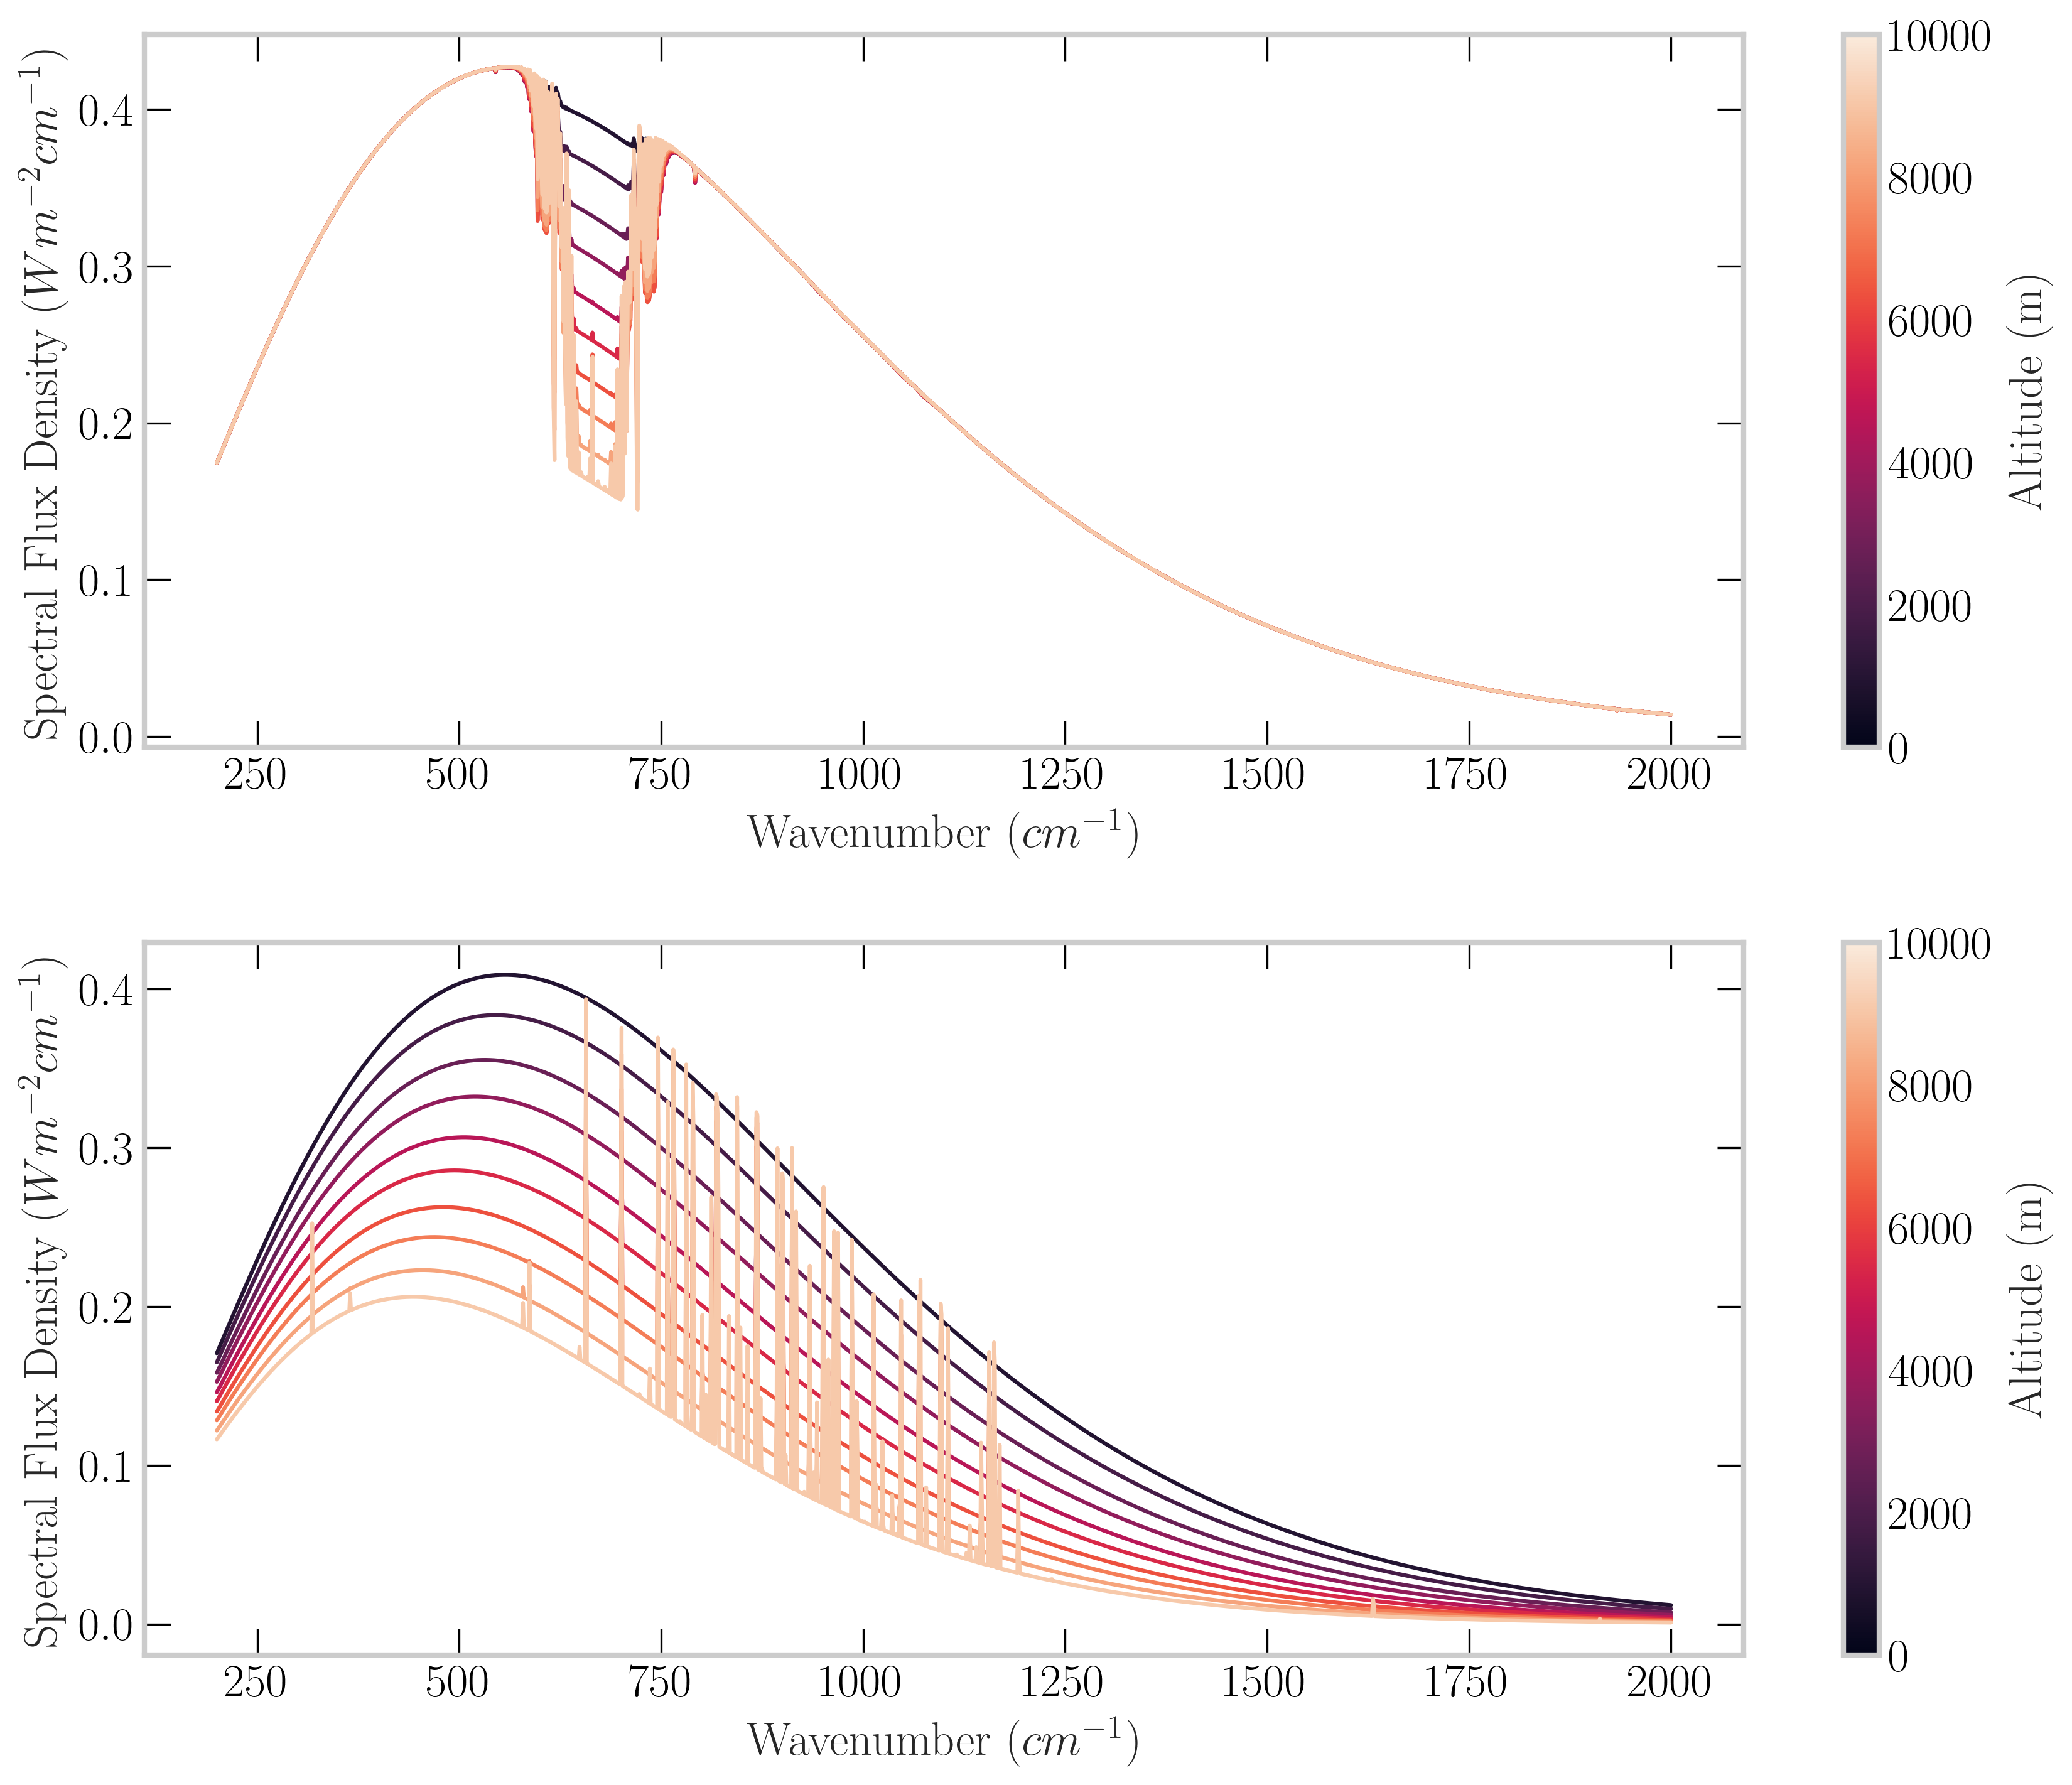

In [17]:
# Setting up the Grids
co2_grid = AtmosphereGrid((0,10000), (200, 2000), "CO2")
water_grid = AtmosphereGrid((0,10000), (200, 2000), "H2O")
water_atm_flux = water_grid.flux_up()
co2_atm_flux = co2_grid.flux_up()
#Plotting
fig, ax = plt.subplots(2,1, figsize=(12,10))
sm = plt.cm.ScalarMappable(
    cmap="rocket", norm=plt.Normalize(vmin=0, vmax=10000)
)

for axs in ax: axs.set_prop_cycle(color=sns.color_palette("rocket", 10))
for axs in ax: axs.set_xlabel("Wavenumber $(cm^{-1})$")
for axs in ax: axs.set_ylabel("Spectral Flux Density $(Wm^{-2} cm^{-1})$")

ax[0].plot(co2_grid.wave_no_bins, co2_atm_flux)
ax[1].plot(water_grid.wave_no_bins, water_atm_flux)

cb_1 = fig.colorbar(sm, ax=ax[0])
cb_2 = fig.colorbar(sm, ax=ax[1])
cb_1.set_label("Altitude (m)")
cb_2.set_label("Altitude (m)")

When using the `AtmosphereGrid` implementation of SimpleTrans, we can look at a limited range of wavenumbers. As an example we focus on the most prominent peaks. This highlights the decreased peak width due to increased altitude.

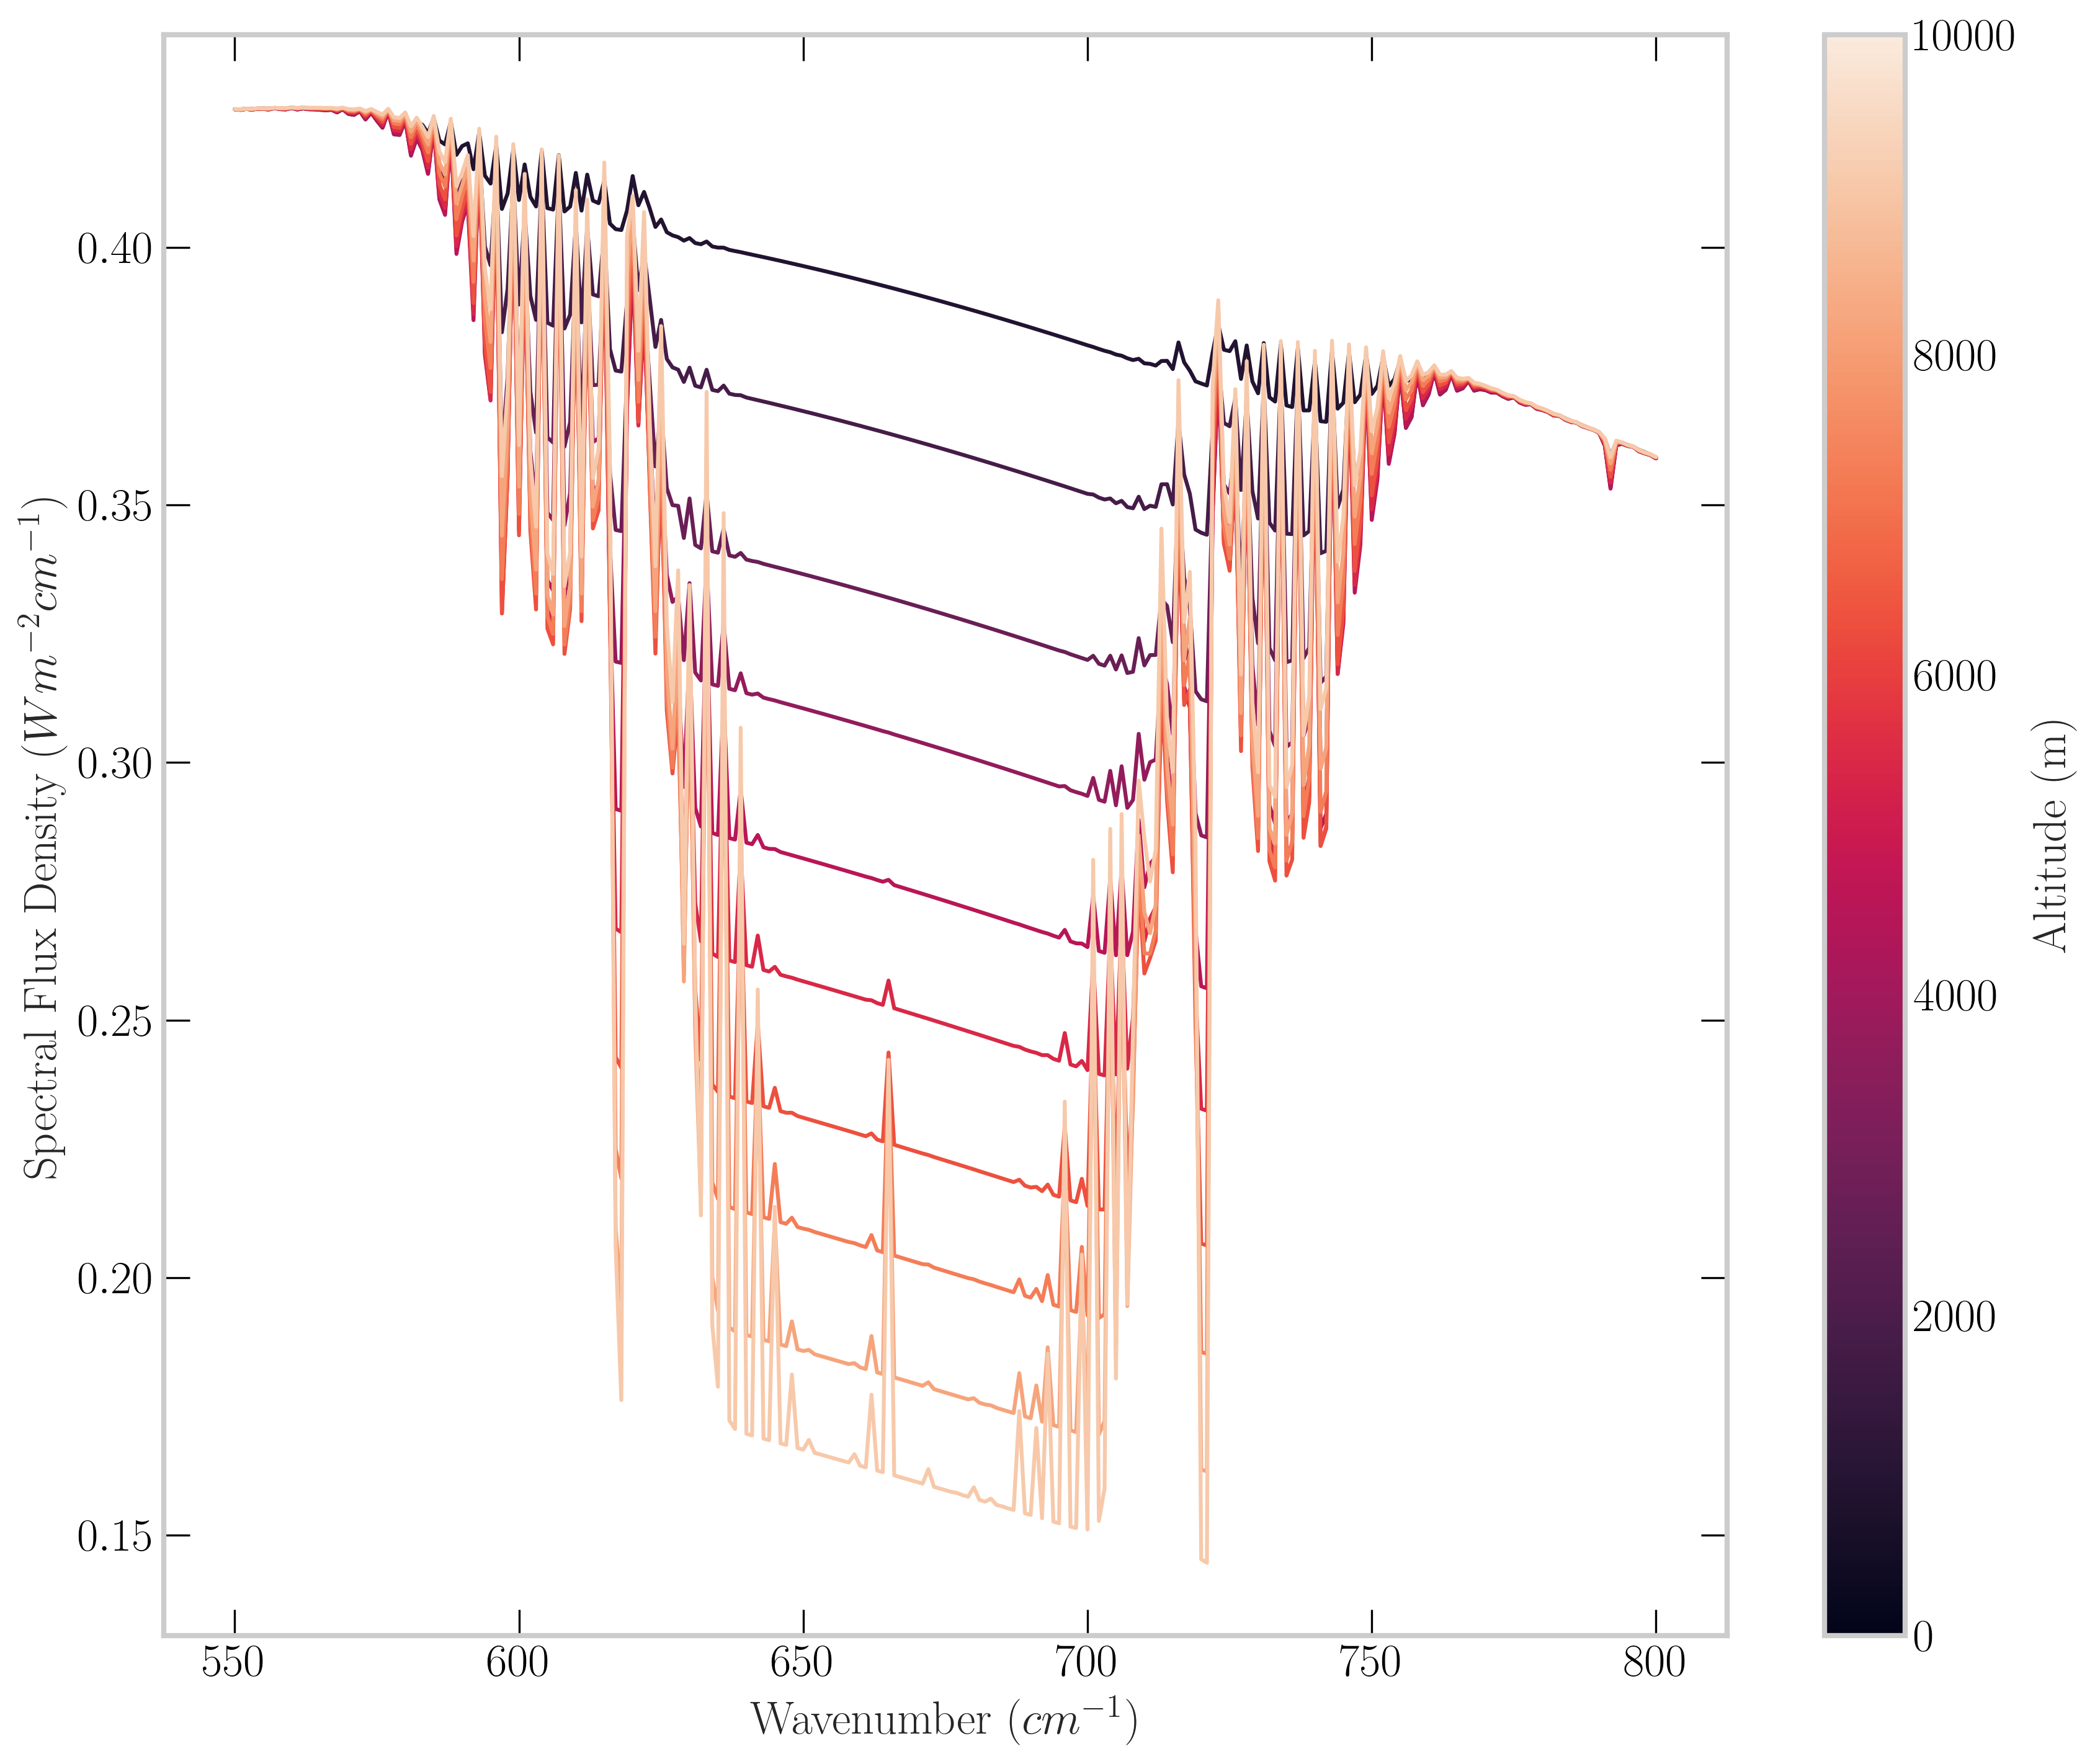

In [15]:
# Using SimpleTrans on a smaller wavenumber range.
atm_grid = AtmosphereGrid((0,10000), (550, 800), "CO2")
atm_flux = atm_grid.flux_up()
# Plotting
fig, ax = plt.subplots( figsize=(12,10))
sm = plt.cm.ScalarMappable(
    cmap="rocket", norm=plt.Normalize(vmin=0, vmax=10000)
)
ax.set_prop_cycle(color=sns.color_palette("rocket", 10))
ax.plot(atm_grid.wave_no_bins, atm_flux)
ax.set_xlabel("Wavenumber $(cm^{-1})$")
ax.set_ylabel("Spectral Flux Density $(Wm^{-2} cm^{-1})$")

cb_2 = fig.colorbar(sm, ax=ax)
cb_1.set_label("Altitude (m)")
cb_2.set_label("Altitude (m)")

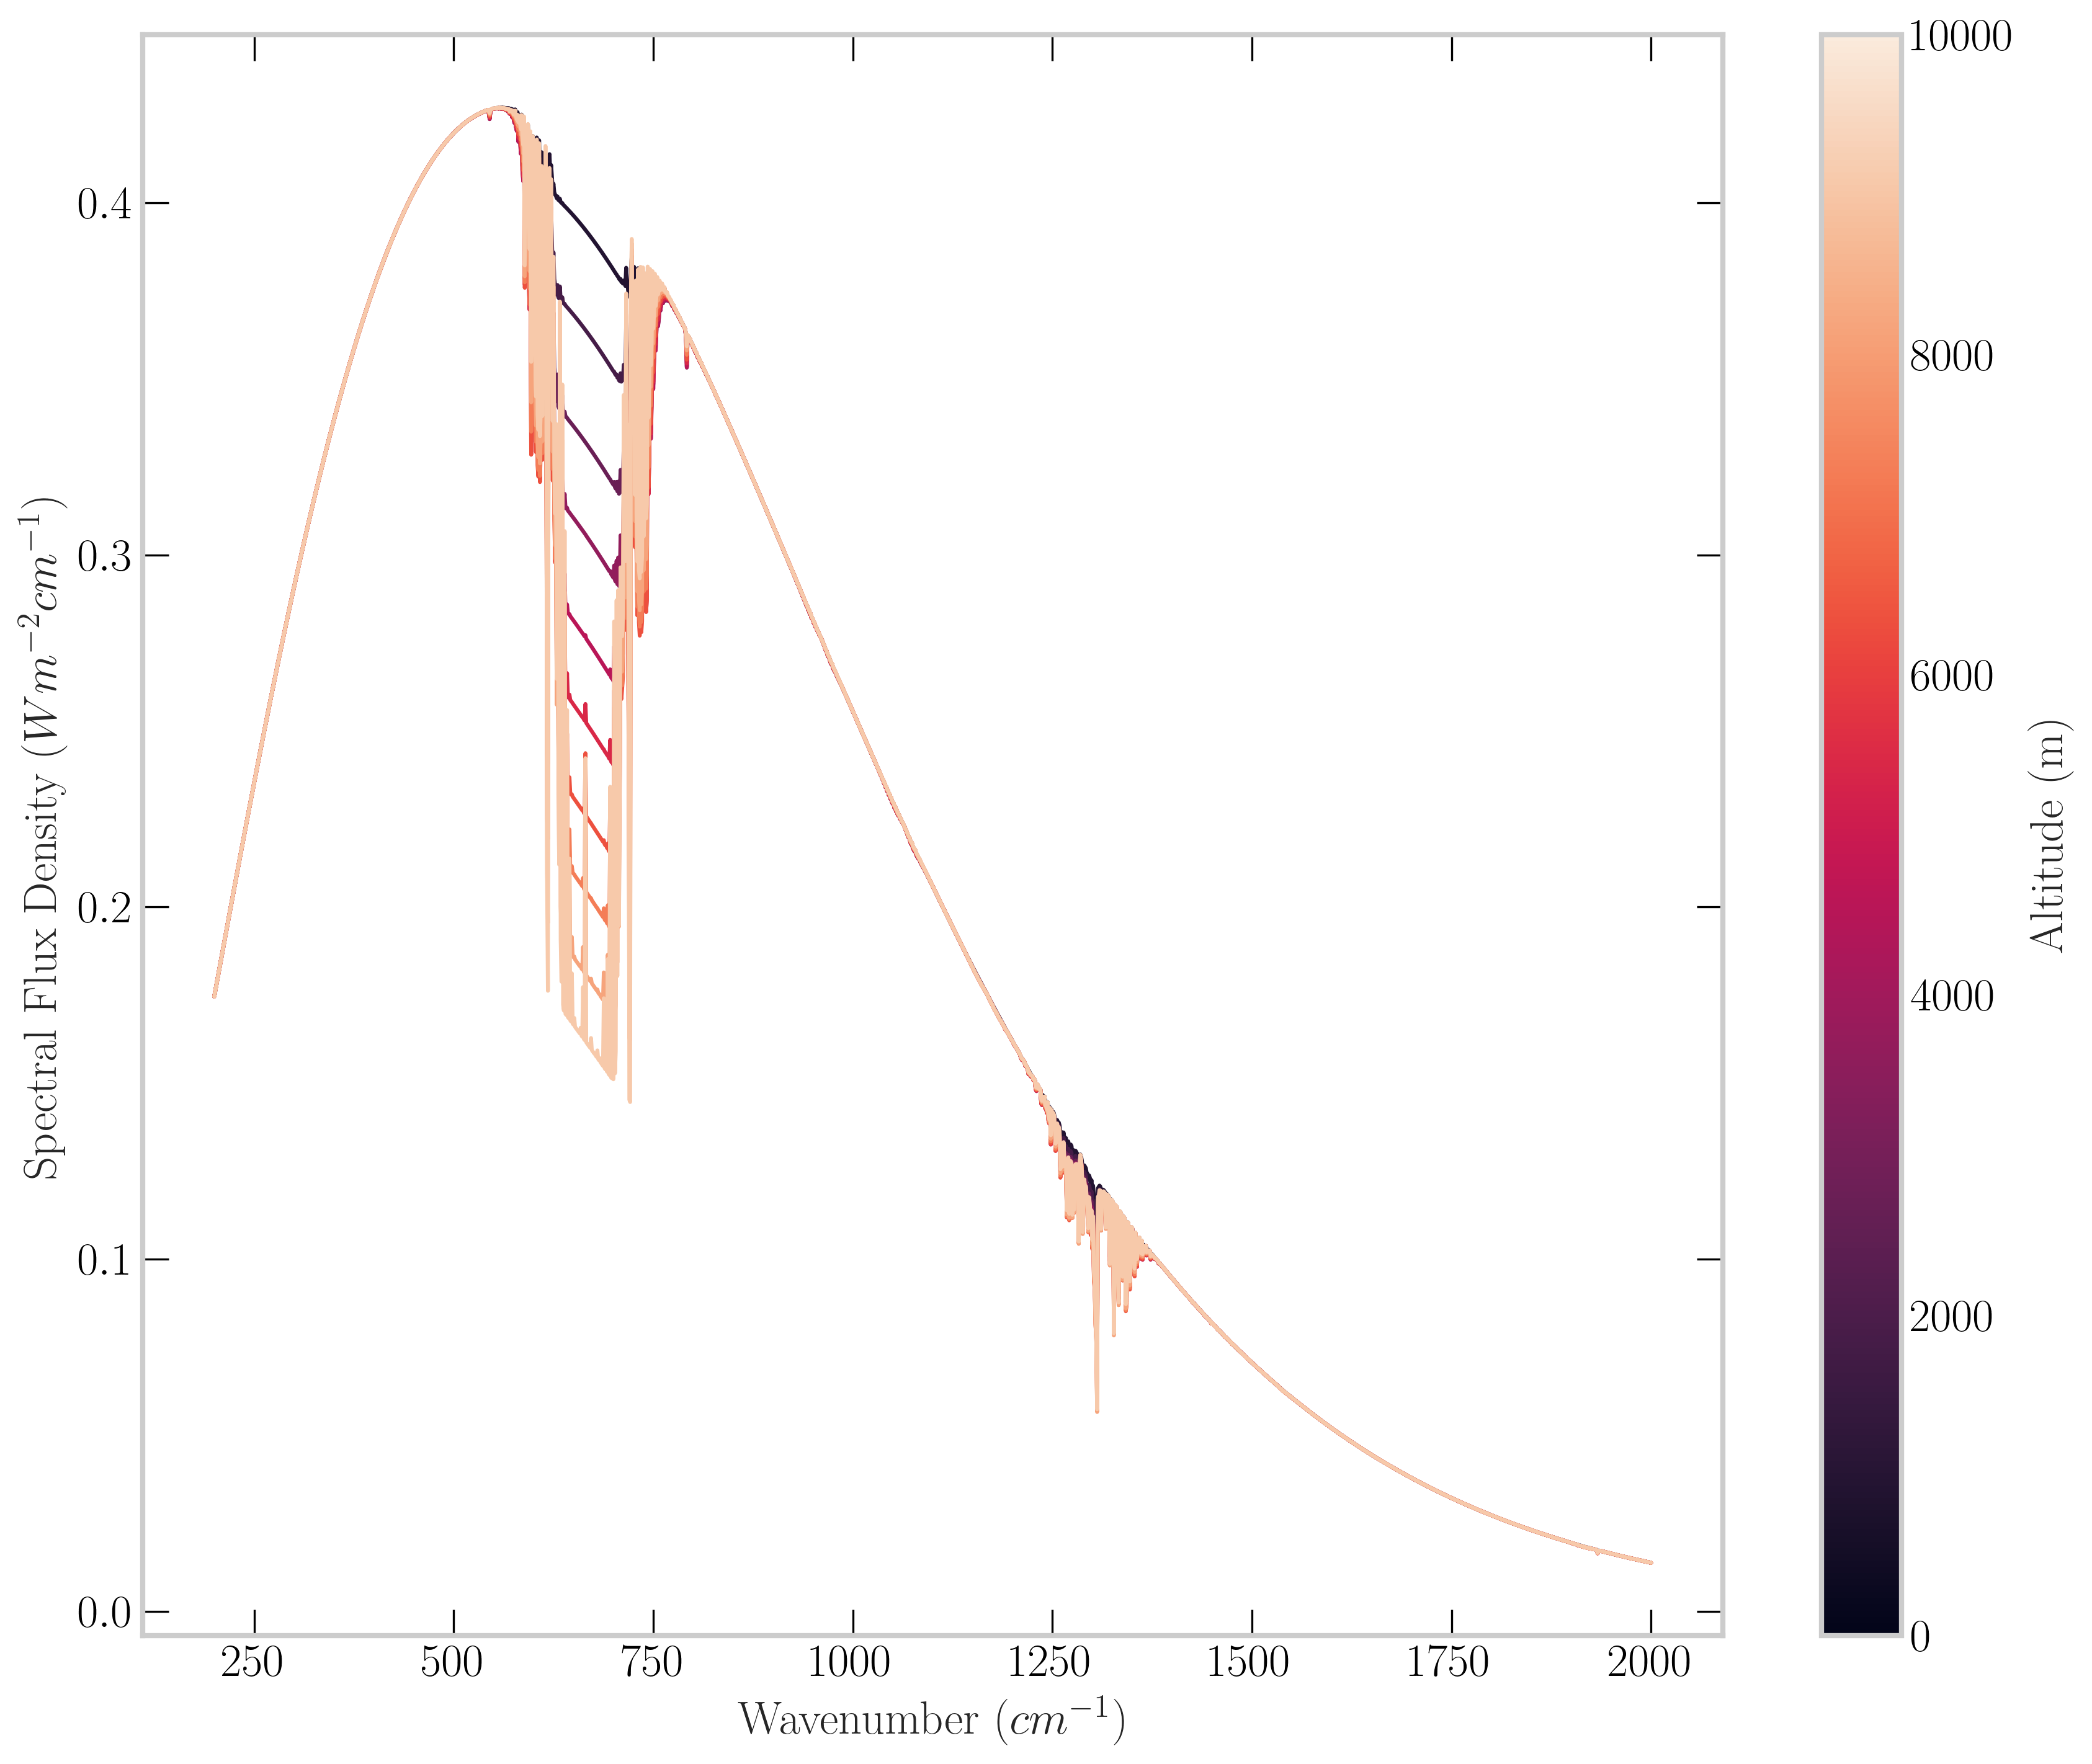

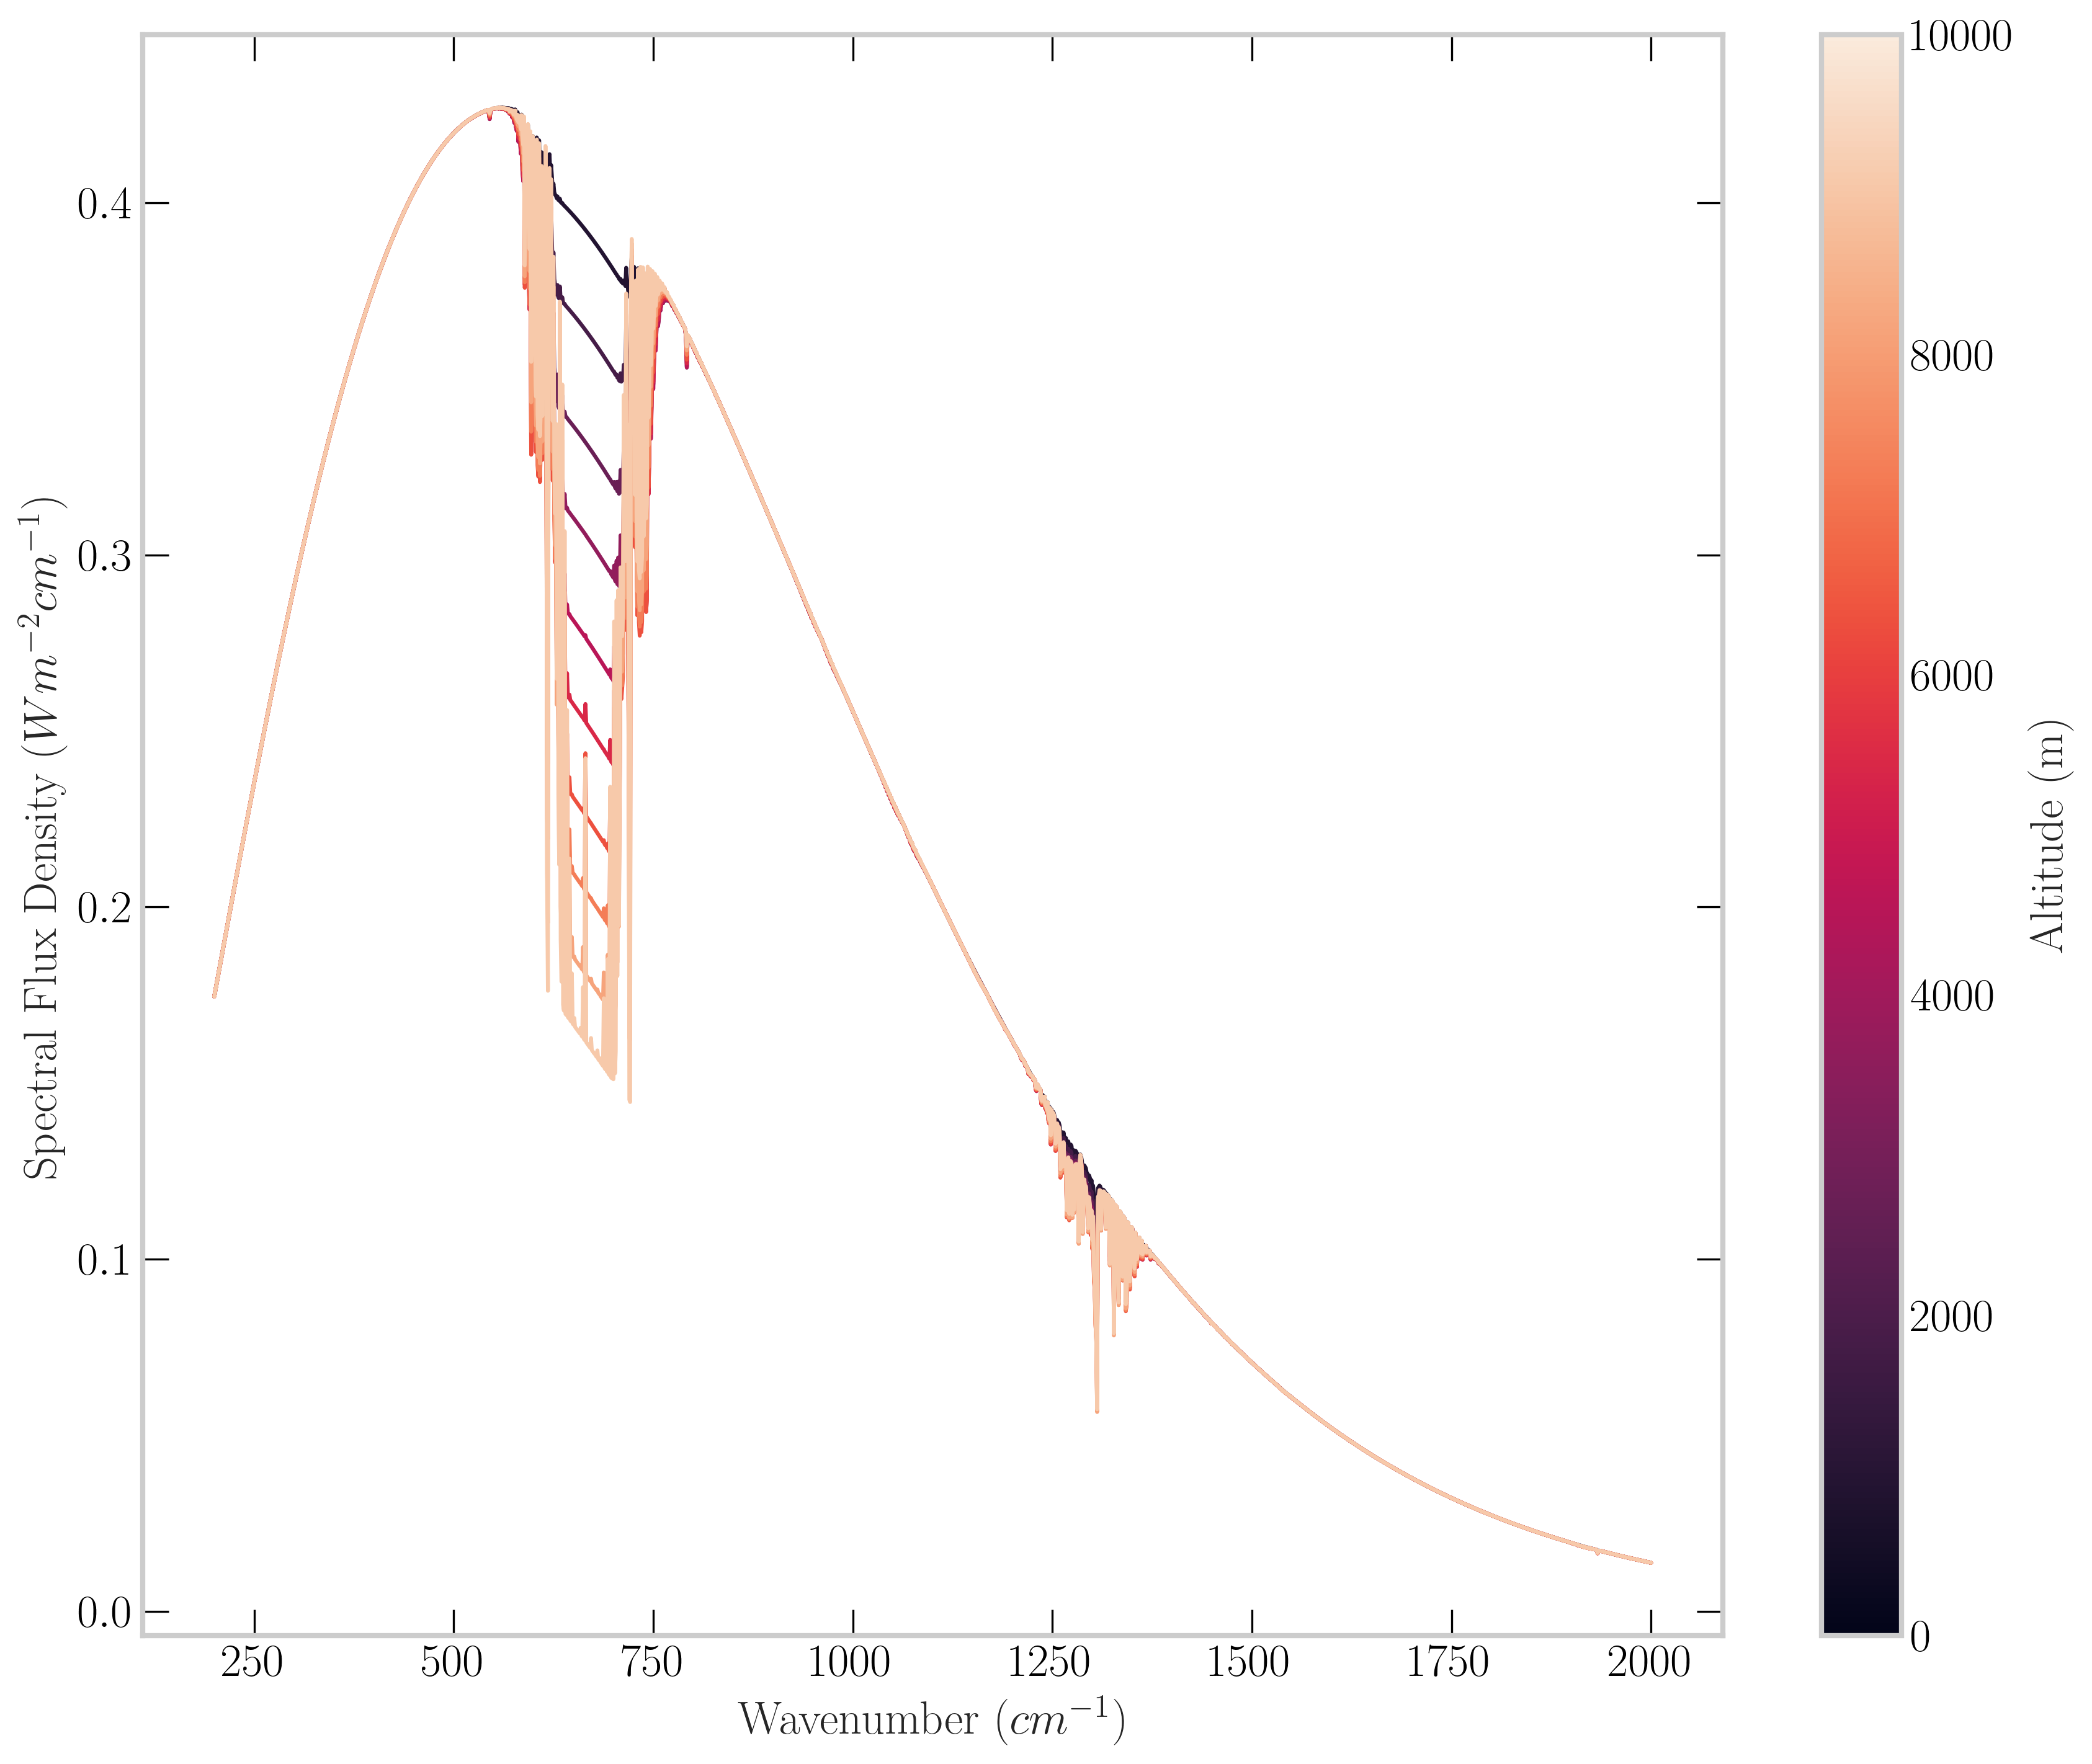

In [16]:
# Using SimpleTrans on a smaller wavenumber range.
atm_grid = AtmosphereGrid((0,10000), (200, 2000), "CO2", "N2O", "CH4")
atm_flux = atm_grid.flux_up()
# Plotting
fig, ax = plt.subplots( figsize=(12,10))
sm = plt.cm.ScalarMappable(
    cmap="rocket", norm=plt.Normalize(vmin=0, vmax=10000)
)
ax.set_prop_cycle(color=sns.color_palette("rocket", 10))
ax.plot(atm_grid.wave_no_bins, atm_flux)
ax.set_xlabel("Wavenumber $(cm^{-1})$")
ax.set_ylabel("Spectral Flux Density $(Wm^{-2} cm^{-1})$")

cb_2 = fig.colorbar(sm, ax=ax)
cb_1.set_label("Altitude (m)")
cb_2.set_label("Altitude (m)")